# Word2Vec (Skipgram )

In [81]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [82]:
import torch

torch.cuda.is_available()

True

In [83]:
torch.cuda.current_device(), torch.cuda.get_device_name(0)


(0, 'NVIDIA GeForce RTX 3050 Laptop GPU')

In [84]:
np.__version__, torch.__version__

('2.3.4', '2.9.1+cu130')

In [85]:
import matplotlib
matplotlib.__version__

'3.10.7'

## 1. Load data

### Dataset: Reuters-21578 (NLTK)

We train on the **Reuters-21578** newswire corpus distributed with the **NLTK** library (`nltk.corpus.reuters`). This provides real-world news text categorized by topic.

**Source/Credit:** Reuters-21578 corpus as packaged by NLTK.

In [86]:
# Load a real-world corpus: Reuters-21578 (news) from NLTK

import nltk

nltk.download("punkt")
nltk.download("punkt_tab")   # <-- this is the one your error is asking for
nltk.download("reuters")
from nltk.corpus import reuters
from collections import Counter

# Download once (safe to call repeatedly)
nltk.download('reuters')

def preprocess_sentence(tokens):
    """Lowercase and keep alphabetic tokens only."""
    return [t.lower() for t in tokens if t.isalpha()]

# Reuters sentences are already tokenized by NLTK
raw_sents = reuters.sents()
corpus = [preprocess_sentence(s) for s in raw_sents]
corpus = [s for s in corpus if len(s) >= 3]

# (Optional) limit the number of sentences for faster training during development
MAX_SENTS = 5000
corpus = corpus[:MAX_SENTS]

len(corpus), corpus[0][:20]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


(5000,
 ['asian',
  'exporters',
  'fear',
  'damage',
  'from',
  'u',
  's',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'between',
  'the',
  'u',
  's',
  'and',
  'japan',
  'has',
  'raised'])

In [87]:
# Preview a few tokenized sentences
corpus[:3]


[['asian',
  'exporters',
  'fear',
  'damage',
  'from',
  'u',
  's',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'between',
  'the',
  'u',
  's',
  'and',
  'japan',
  'has',
  'raised',
  'fears',
  'among',
  'many',
  'of',
  'asia',
  's',
  'exporting',
  'nations',
  'that',
  'the',
  'row',
  'could',
  'inflict',
  'far',
  'reaching',
  'economic',
  'damage',
  'businessmen',
  'and',
  'officials',
  'said'],
 ['they',
  'told',
  'reuter',
  'correspondents',
  'in',
  'asian',
  'capitals',
  'a',
  'u',
  's',
  'move',
  'against',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'in',
  'the',
  'u',
  's',
  'and',
  'lead',
  'to',
  'curbs',
  'on',
  'american',
  'imports',
  'of',
  'their',
  'products'],
 ['but',
  'some',
  'exporters',
  'said',
  'that',
  'while',
  'the',
  'conflict',
  'would',
  'hurt',
  'them',
  'in',
  'the',
  'long',
  'run',
  'in',
  'the',
  'short',
  'term',
  'tokyo',
  's',
  'loss'

In [88]:
# Build vocabulary (frequency-based) and add <UNK>

VOCAB_SIZE = 10000  # including <UNK>

counts = Counter(token for sent in corpus for token in sent)
most_common = counts.most_common(VOCAB_SIZE - 1)
vocabs = [w for w, _ in most_common]
vocabs.append('<UNK>')

word2index = {w: i for i, w in enumerate(vocabs)}
index2word = {i: w for w, i in word2index.items()}

len(vocabs), vocabs[:10]


(8651, ['the', 'of', 'to', 'in', 'and', 'said', 'a', 'mln', 's', 'vs'])

In [89]:
# Sanity checks
word2index.get('oil', word2index['<UNK>']), index2word[word2index.get('oil', word2index['<UNK>'])]


(76, 'oil')

In [90]:
# Example of unknown token handling
word2index.get('this_token_is_not_in_vocab', word2index['<UNK>'])


8650

In [91]:
# Vocabulary size
len(word2index)


8651

## 2. Prepare train data

In [92]:
# Create (center, context) pairs for Skip-gram with a dynamic window size

def random_batch(batch_size, corpus, window_size=2):
    """
    window_size: number of words to the left/right to consider (default=2).
    For each center token, we create pairs with all context tokens within +/- window_size.
    """

    skipgrams = []

    for sent in corpus:
        for i in range(len(sent)):
            center_word = sent[i]
            center = word2index.get(center_word, word2index['<UNK>'])

            # collect context within the window
            for offset in range(1, window_size + 1):
                left_i = i - offset
                right_i = i + offset

                if left_i >= 0:
                    left_word = sent[left_i]
                    outside = word2index.get(left_word, word2index['<UNK>'])
                    skipgrams.append([center, outside])

                if right_i < len(sent):
                    right_word = sent[right_i]
                    outside = word2index.get(right_word, word2index['<UNK>'])
                    skipgrams.append([center, outside])

    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)

    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])

    return np.array(inputs), np.array(labels)

# default window_size=2
x, y = random_batch(2, corpus)


In [93]:
x.shape  #batch_size, 1

(2, 1)

In [94]:
x

array([[ 10],
       [268]])

In [95]:
y.shape  #batch_size 1

(2, 1)

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [96]:
len(vocabs)

8651

In [97]:
embedding = nn.Embedding(len(vocabs), 2)
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape  #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [98]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [99]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[   0,    1,    2,  ..., 8648, 8649, 8650],
        [   0,    1,    2,  ..., 8648, 8649, 8650]])

In [100]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(8651, 2)
  (embedding_outside): Embedding(8651, 2)
)

In [101]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [102]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [103]:
loss

tensor(14.1194, grad_fn=<NegBackward0>)

## 4. Training

In [104]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [105]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 10.131212
Epoch   2000 | Loss: 9.119822
Epoch   3000 | Loss: 8.810076
Epoch   4000 | Loss: 10.282796
Epoch   5000 | Loss: 9.605095
Epoch   6000 | Loss: 8.449777
Epoch   7000 | Loss: 7.618790
Epoch   8000 | Loss: 8.680080
Epoch   9000 | Loss: 9.013293
Epoch  10000 | Loss: 9.211825


## 5. Plot the embeddings

Is fruit really near to banana?
Is fruit really far from cat?

In [106]:
vocabs

['the',
 'of',
 'to',
 'in',
 'and',
 'said',
 'a',
 'mln',
 's',
 'vs',
 'for',
 'dlrs',
 'it',
 'pct',
 'on',
 'lt',
 'cts',
 'at',
 'from',
 'that',
 'its',
 'by',
 'is',
 'net',
 'year',
 'be',
 'billion',
 'was',
 'u',
 'with',
 'has',
 'will',
 'as',
 'he',
 'an',
 'company',
 'not',
 'would',
 'nil',
 'shr',
 'last',
 'tonnes',
 'loss',
 'inc',
 'are',
 'were',
 'but',
 'corp',
 'bank',
 'this',
 'which',
 'they',
 'share',
 'qtr',
 'trade',
 'one',
 'have',
 'shares',
 'april',
 'or',
 'market',
 'first',
 'quarter',
 'had',
 'about',
 'japan',
 'new',
 'dollar',
 'may',
 'also',
 'price',
 'profit',
 'sales',
 'two',
 'stock',
 'exports',
 'oil',
 'per',
 'been',
 'week',
 'more',
 'up',
 'than',
 'after',
 'note',
 'rate',
 'co',
 'total',
 'revs',
 'march',
 'other',
 'imports',
 'end',
 'month',
 'rates',
 'some',
 'group',
 'we',
 'production',
 'stocks',
 'stg',
 'government',
 'prices',
 'agreement',
 'interest',
 'offer',
 'exchange',
 'wheat',
 'yen',
 'today',
 'no',


In [107]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([6030])

In [108]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[0.5570, 0.0729]], grad_fn=<DivBackward0>)

In [109]:
banana_embed_o

tensor([[ 0.7711, -0.5934]], grad_fn=<EmbeddingBackward0>)

In [110]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [111]:
get_embed('fruit')

(0.7156800627708435, -0.16251203417778015)

In [112]:
get_embed('cat')

(0.5285777449607849, -0.19458188116550446)

In [116]:
get_embed('king')

(0.42907968163490295, -0.39748722314834595)

In [117]:
get_embed('queen')

(0.38065531849861145, 0.15288066864013672)

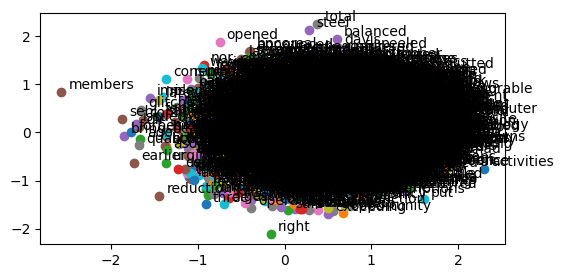

In [118]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [119]:
banana = get_embed('banana')
banana

(0.5570362210273743, 0.07291299104690552)

In [120]:
fruit = get_embed('fruit')
fruit

(0.7156800627708435, -0.16251203417778015)

In [121]:
unk = get_embed('<UNK>')
unk

(0.12512467801570892, 0.15185382962226868)

In [122]:
np.array(banana) @ np.array(unk)

np.float64(0.08077109471882427)

In [123]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

0.7307008731832124
0.9381869696347802
